---
#### CIS 522 Final Project

# Classify the X Ray image which is having Corona
### *CoronaHack - Chest X-Ray-Dataset*
<br/>

## Zehang Chen, Anni Pan, Mary Qin

## Imports and Download

In [ ]:
# @title Import Required Libraries
%%capture
import os
import csv
import json
import random
import pathlib

import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from IPython.display import HTML, display
from PIL import Image

import pickle
from joblib import dump, load
import torchvision.models as models
import ipywidgets as widgets

!pip install -U scikit-learn
!pip install grad-cam
!pip install ttach
from pytorch_grad_cam import GradCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM
import torchvision.transforms as transforms
from pytorch_grad_cam.utils.image import show_cam_on_image

In [ ]:
# @title Check Training Environment

dev = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dev, torch.get_num_threads()

(device(type='cuda'), 1)

In [ ]:
# @title Install Kaggle API (run me)
%%capture
!pip install --upgrade --force-reinstall --no-deps kaggle==1.5.10
!kaggle -v

In [ ]:
# @title Fetch Kaggle Authentication File
%%capture
from google_drive_downloader import GoogleDriveDownloader as gdd
gdd.download_file_from_google_drive(file_id='13zNuYPQdWRZ2ytY8yofe1dcOa_1RnhAP', dest_path='/content/kaggle.json')

In [ ]:
# @title Registering API key
%%capture
!rm -r /root/.kaggle
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# @title Downloading Dataset
%%capture
!kaggle datasets download -d praveengovi/coronahack-chest-xraydataset
!unzip coronahack-chest-xraydataset.zip

## 1. Set up datasets

In [ ]:
# locations for training pictures and test datasets
trainLoc = '/content/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/train'
testLoc = '/content/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/test'

# uniformed picture dimension
picDim = (256, 256)

# file contain label information
labels = pd.read_csv('/content/Chest_xray_Corona_Metadata.csv')

# define new exception types
class NoMatadataError(Exception): pass
class ExcludeError(Exception): pass

# function for getting the full list of paths in either training or testing set
# each location is stored in a dictionary in two ways:
#   - full: full path for accessing the picture
#   - short: filename for getting label
def getPathList(folderLoc):
    fileLocs = []
    for dirname, _, filenames in os.walk(folderLoc):
        for filename in filenames: fileLocs.append({'full': os.path.join(dirname, filename), 'short': filename})
    return fileLocs

trainFilePaths, testFilePaths = getPathList(trainLoc), getPathList(testLoc)

# function for getting pixel values if an image
# index: the number of pictures in the set
# setName: specify either train set or test set
# all images are resized to picDim and to grayscale for shape consistency
def getPixel(index, setName, outputDim=picDim):
    if setName == 'train': path = trainFilePaths[index]
    if setName == 'test':  path = testFilePaths[index]
    if path['short'] not in set(labels.X_ray_image_name): raise NoMatadataError
    im = Image.open(path['full'])
    if im.mode != 'L': im = im.convert('L')
    return np.array(im.resize(outputDim).getdata())

# funcion for getting label of an image
# 0-normal; 1-virus; 2-bacteria
# stress smoking/ards are excluded due to insufficient data (n=2)
def getLabel(index, setName): 
    if setName == 'train': curLabels = labels.loc[labels['X_ray_image_name']==trainFilePaths[index]['short']]
    if setName == 'test':  curLabels = labels.loc[labels['X_ray_image_name']==testFilePaths[index]['short']]
    label, label1, label2 = curLabels.Label.values[0], curLabels.Label_1_Virus_category.values[0], curLabels.Label_2_Virus_category.values[0]
    if label1 == 'Stress-Smoking': raise ExcludeError
    if label == 'Normal': return 0
    if label1 == 'Virus': return 1
    if label1 == 'bacteria': return 2

def translateLabel(label): return {0: 'Normal', 1: 'Virus', 2: 'Bacteria'}[label]

# function for getting a batch of data with labels
# result in returned in a dictionary with 3 items
#   data  - torch.tensor with shape (batchSize, *imageSize), default imageSize=picDim
#   label - torch.tensor with shape (batchSize)
#   batchSize - int equal to batchSize, this may be smaller than maxBatchSize at the end of the dataset
# if flattened=True: 
#   image will be flattened and data will be with shape (batchSize, *pixelNumber)
#   this may be useful in non-deep learning models
# if progress=True:
#   a progress bar will be shown
def getBatch(startIndex, maxBatchSize, setName='train', outputDim=picDim, flattened=False, progress=False):
    data, curr_labels, i, e = [], [], 0, 0
    if progress: r = tqdm(range(maxBatchSize), ascii=True, ncols=120, desc=setName)
    else: r = range(maxBatchSize)
    for i in r:
        try:
            if not flattened: curData = getPixel(startIndex+i, setName, outputDim).reshape(*outputDim)
            if flattened:  curData = getPixel(startIndex+i, setName, outputDim)
            curr_labels.append(getLabel(startIndex+i, setName))
            data.append(curData)
        except IndexError: break
        except (NoMatadataError, ExcludeError) as error: e+=1
    return {'data': torch.tensor(data), 'label': torch.tensor(curr_labels), 'batchSize': i-e+1}

In [ ]:
# @title Label Distribution
df = labels.replace(np.nan,'NA').groupby(by=['Dataset_type','Label','Label_1_Virus_category']).count()[['Unnamed: 0']].rename(columns={'Unnamed: 0':'Count'})
with open('/content/1_labelDistribution.tex', 'w') as f: 
  f.write(df.reset_index().to_latex(index=True))
  f.close()
df

Count
Dataset_type Label    Label_1_Virus_category       
TEST         Normal   NA                        234
             Pnemonia Virus                     148
                      bacteria                  242
TRAIN        Normal   NA                       1342
             Pnemonia Stress-Smoking              2
                      Virus                    1407
                      bacteria                 2535

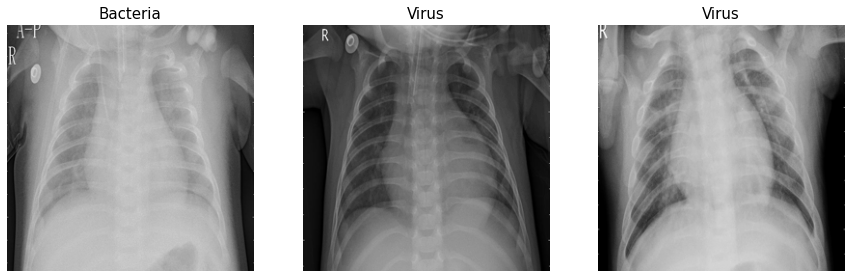

In [ ]:
# @title Sample Images
dispLabels = [getLabel(i, 'train') for i in range(8,11)]
dispImages = [Image.open(trainFilePaths[i]['full']).resize(picDim) for i in range(8,11)]

fig, axes = plt.subplots(1, 3, figsize=(15, 50))
for ax, im, lb in zip(axes, dispImages, dispLabels):
  ax.imshow(im, cmap='gray')
  ax.axis('off')
  ax.set_title(translateLabel(lb), size=15)

plt.savefig('/content/1_sampleImages.svg')

## 2. Baseline Model

To establish the baseline, a multiple logistic classifier was implemented. Note this model requires additional memory to train and is trained using an external drive with the result saved. Testing dataset is much smaller than training dataset, and the score section should be able to run directly from google colab without issue given the trained model is available.

In [ ]:
# @title Attempt to fetch training result
%%capture
gdd.download_file_from_google_drive(file_id='1de1jiDG-pyCXHpvBZ7nu-XMjm81yXjdW', dest_path='/content/baseModel256.joblib')
gdd.download_file_from_google_drive(file_id='1gtHyIn8ffuTdG4GTjz6WKrKFb3kezxgH', dest_path='/content/baseModel512.joblib')

test: 100%|###########################################################################| 624/624 [00:15<00:00, 40.02it/s]
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator LogisticRegression from version 0.24.1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


Accuracy for baseline model (naive logistic classifier) is 61.538%.


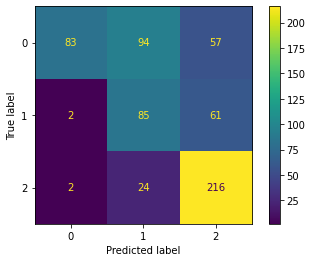

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

baseResPath = '/content/baseModel' + str(picDim[0]) + '.joblib'
allTest = getBatch(0, len(testFilePaths), 'test', flattened=True, progress=True)

if os.path.exists(baseResPath): baseModel = load(baseResPath)
else:
    allTrain = getBatch(0, len(trainFilePaths), 'train', flattened=True, progress=True)
    baseModel = LogisticRegression(penalty='none', solver='saga', max_iter=10000, n_jobs=-1).fit(allTrain['data'].numpy(), allTrain['label'].numpy())
    with open(baseResPath, 'wb') as f: dump(baseModel, f)

baseAcc = baseModel.score(allTest['data'].numpy(), allTest['label'].numpy())
print('Accuracy for baseline model (naive logistic classifier) is %5.3f%%.'%(baseAcc*100))

cm = confusion_matrix(allTest['label'].numpy(), baseModel.predict(allTest['data'].numpy()), labels=baseModel.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=baseModel.classes_)
disp.plot() # 0-normal; 1-virus; 2-bacteria
plt.savefig('/content/2_cmBaseModel.svg')

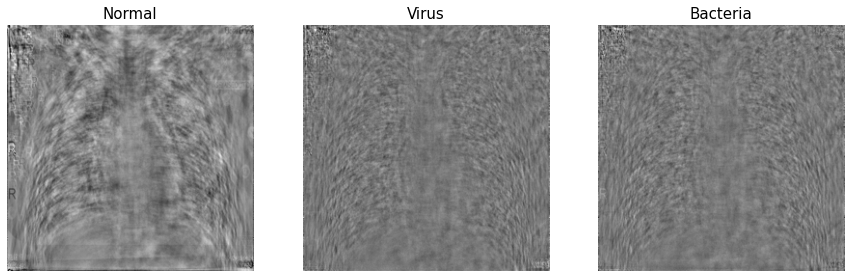

In [ ]:
# @title Logistic classifier filters
baseCoef = baseModel.coef_
baseImages = [baseCoef[i,].reshape(picDim) for i in range(3)]

fig, axes = plt.subplots(1, 3, figsize=(15, 50))
for ax, im, lb in zip(axes, baseImages, range(3)):
  ax.imshow(im, cmap='gray')
  ax.axis('off')
  ax.set_title(translateLabel(lb), size=15)

plt.savefig('/content/2_logisticClassifierFilter.svg')

## 3. Simple Deep Learning Model

### Load Data

In [ ]:
import torchvision.transforms as transforms
from functools import partial
tqdm = partial(tqdm, position=0, leave=True)

def getData(startIndex, maxBatchSize, setName='train', outputDim=picDim, flattened=False, progress=False):
    transform = transforms.Compose(
    [ transforms.ToTensor(),
      transforms.Normalize((128), (128))])
  
    data, i, e = [], 0, 0
    if progress: r = tqdm(range(maxBatchSize), ascii=True, ncols=120, desc=setName)
    else: r = range(maxBatchSize)
    for i in r:
        try:
            if not flattened: curData = getPixel(startIndex+i, setName, outputDim).astype(dtype='float64').reshape(*picDim)
            if flattened:  curData = getPixel(startIndex+i, setName, outputDim).astype(dtype='float64')
            data.append((transform(curData), getLabel(startIndex+i, setName)))
        except IndexError: break
        except (NoMatadataError, ExcludeError) as error: e+=1
    return data

In [ ]:
trainset = getData(0, len(trainFilePaths), 'train', flattened=False, progress=True)
testset = getData(0, len(testFilePaths), 'test', flattened=False, progress=True)

test: 100%|###########################################################################| 624/624 [00:15<00:00, 40.12it/s]


In [ ]:
BATCH_SIZE = 100
validationset, trainset = torch.utils.data.random_split(trainset, [800, len(trainset)-800])

trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
validationloader = torch.utils.data.DataLoader(validationset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

### Basic Functions

In [ ]:
def train(model, device, train_loader, validation_loader, epochs, criterion, optimizer):
  # Params:
  #   model-> instance of your model which extends nn.Module class
  #   device -> it is set to cuda already and is already stored in a variable called *device*
  #   train_loader -> dataloader for train dataset, already stored in a variable called *trainloader*
  #   validation_loader -> dataloader for validation dataset, already stored in a variable called *validationloader*
  #   epochs -> number of epochs for training, you are expected to experiment and play around with this
  #   criterion -> the loss function which you decide to use
  #   optimizer -> optimizer for your gradient descent, do not forget to set an appropriate learning rate
  #  Returns:  train_loss, train_accuracy, validation_loss, validation_accuracy, all of these are lists storing the values 
    
    train_loss, validation_loss = [], []
    train_acc, validation_acc = [], []
    for epoch in range(epochs):
        model.train()
        running_loss = 0.
        correct, total = 0, 0 
        # train on the train dataset
        with tqdm(train_loader, unit='batch') as tepoch:
            tepoch.set_description('Training: ')
            for data, target in tepoch:
                data, target = data.to(device), target.to(device)
                optimizer.zero_grad()
                output = model(data.float())
                _, predicted = torch.max(output, 1)
                total += output.size(0)
                correct += (predicted == target).sum().item()
                
                running_loss = criterion(output, target)
                running_loss.backward()
                optimizer.step()
                tepoch.set_postfix(running_loss=running_loss.item())
                 
        train_loss.append(running_loss)
        train_acc.append(100 * correct / total)
                
        # evaluate on validation data
        model.eval()
        running_loss = 0.
        correct, total = 0, 0 
        with tqdm(validation_loader, unit='batch') as tepoch:
            tepoch.set_description('Validation: ')
            for data, labels in tepoch:
              data, labels = data.to(device), labels.to(device)

              outputs = model(data.float())
              _, predicted = torch.max(outputs, 1)
              total += outputs.size(0)
              correct += (predicted == labels).sum().item()
              
              running_loss = criterion(outputs, labels)  # sum up batch loss
              tepoch.set_postfix(running_loss=running_loss.item())
              
              
        validation_acc.append(100 * correct / total)
        validation_loss.append(running_loss)
    
    return train_loss, train_acc, validation_loss, validation_acc 

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
def test(model, device, data_loader):
  # Params:
  #   model-> instance of your trained model which extends nn.Module class
  #   device -> it is set to cuda already and is already stored in a variable called *device*
  #   data_loader -> dataloader for test dataset, already stored in a variable called *testloader*
  # Returns:
  #   accuracy(float)-> percentage of correct predictions made by your trained model
    model.eval()
    correct = 0
    total = 0
    all_pred = []
    all_target = []

    for data, target in data_loader:
      data, target = data.to(device), target.to(device)
      output = model(data.float())
      pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
      correct += pred.eq(target.view_as(pred)).sum().item()
      total += output.size(0)

      all_target = np.append(all_target, target.view_as(pred).detach().cpu().numpy())
      all_pred = np.append(all_pred, pred.detach().cpu().numpy())

    # plot confusion matrix
    cm = confusion_matrix(all_target, all_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot() # 0-normal; 1-virus; 2-bacteria

    acc = 100 * correct / total
    print('Accuracy is %5.3f%%.'%(acc))

In [ ]:
def plot_loss_accuracy(train_loss, train_acc, validation_loss, validation_acc):
    epochs = len(train_loss)
    fig, (ax1, ax2) = plt.subplots(1, 2)
    ax1.plot(list(range(epochs)), train_loss, label='Training Loss')
    ax1.plot(list(range(epochs)), validation_loss, label='Validation Loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.set_title('Epoch vs Loss')
    ax1.legend()

    ax2.plot(list(range(epochs)), train_acc, label='Training Accuracy')
    ax2.plot(list(range(epochs)), validation_acc, label='Validation Accuracy')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy')
    ax2.set_title('Epoch vs Accuracy')
    ax2.legend()
    fig.set_size_inches(15.5, 5.5)
    plt.show()

### FeedForward Neural Network

In [ ]:
class FFN(nn.Module):
  def __init__(self):       
    super(FFN, self).__init__()
    self.fc1 = nn.Linear(256*256, 128)
    self.fc2 = nn.Linear(128, 32)
    self.fc3 = nn.Linear(32, 3)

  def forward(self, x):
    x = x.view(x.shape[0],-1)
    x = self.fc1(x)
    x = F.relu(x)
    x = self.fc2(x)
    x = F.relu(x)
    x = self.fc3(x)
    x = F.log_softmax(x, dim=1)
    return x

In [ ]:
net1 = FFN().to(dev)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net1.parameters(), lr=0.01, momentum=0.9)
num_epochs = 20
train_loss, train_acc, validation_loss, validation_acc = train(net1, dev, trainloader, validationloader, num_epochs, criterion, optimizer)

Validation: : 100%|██████████| 8/8 [00:00<00:00, 12.82batch/s, running_loss=0.418]


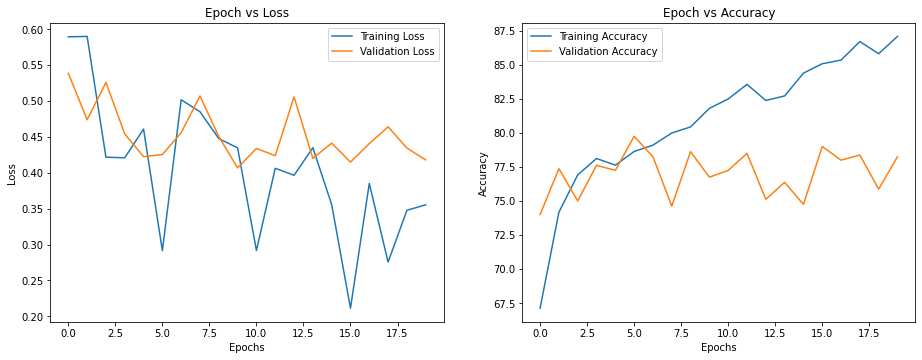

<Figure size 432x288 with 0 Axes>

In [ ]:
plot_loss_accuracy(train_loss, train_acc, validation_loss, validation_acc)
plt.savefig('/content/3_trainFNN.svg')

Accuracy is 65.545%.


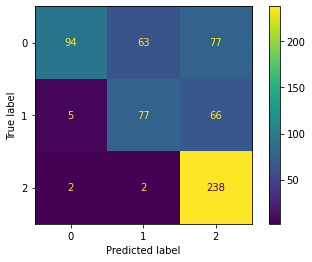

In [ ]:
test(net1, dev, testloader)
plt.savefig('/content/3_cmFNN.svg')

### Convolutional Neural Network

In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=4, kernel_size=3),
            nn.ReLU(),
            nn.Conv2d(in_channels=4, out_channels=8, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        self.fc = nn.Sequential(
            nn.Linear(127008,128),
            nn.Linear(128, 3)
         )
        
    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        output=self.fc(x)
        return output

In [ ]:
net2 = CNN().to(dev)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net2.parameters(), lr=0.01)
num_epochs = 9
train_loss, train_acc, validation_loss, validation_acc = train(net2, dev, trainloader, validationloader, num_epochs, criterion, optimizer)

Validation: : 100%|██████████| 8/8 [00:00<00:00, 13.16batch/s, running_loss=0.573]


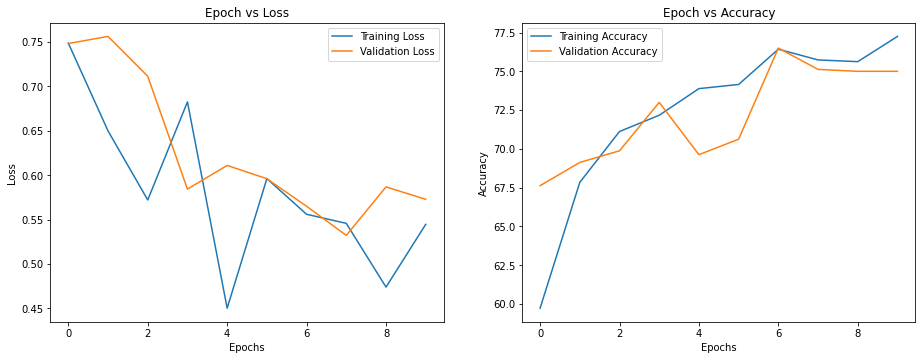

<Figure size 432x288 with 0 Axes>

In [ ]:
plot_loss_accuracy(train_loss, train_acc, validation_loss, validation_acc)
plt.savefig('/content/3_trainCNN.svg')

Accuracy is 65.385%.


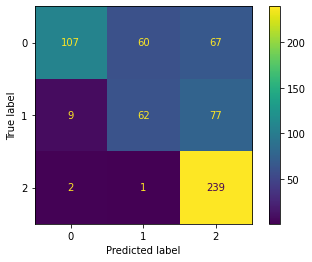

In [ ]:
test(net2, dev, testloader)
plt.savefig('/content/3_cmCNN.svg')

### Visaulize Feature Map

In [ ]:
from skimage.transform import resize
import matplotlib.pyplot as plt

def temp_rem(model,key,input_img):
    model.eval()
    flag=0
    alt_=[]    
    for search in model._modules['features']._modules.keys():
        if flag==1:
            break
        if key==search:
            flag=1
        alt_.append(model._modules['features']._modules[search])
    return torch.nn.Sequential(*alt_).to(dev)(input_img.to(dev).float()).squeeze().detach().cpu().numpy()

def plot(data,Num_Filters,img_original,path=None):
    import matplotlib.pyplot as plt
    i=0
    flag=0
    if Num_Filters>len(data):
        print("Please set Num_Filters parameter less than or equal to the number of filters present in the layer ({} in this case)".format(len(data)))
        return
    if Num_Filters<8:
        fig, ax = plt.subplots(1,Num_Filters, figsize=(15,50))
        for col in ax:
            if flag==0:
                col.imshow(resize(img_original,(256,256)))    
                col.axis('off')
                
                flag=1
            else:
                col.imshow(resize(data[i],(256,256)))
                col.axis('off')
                
            i=i+1
        
        plt.subplots_adjust(wspace=0, hspace=0)
        plt.show()
        if path is not None: plt.savefig(path)
        return

    i=0    
    ncols=4
    nrows=Num_Filters//ncols
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20,10))
    for rows in ax:
        for cols in rows:
            if flag==0:
                cols.imshow(resize(img_original,(256,256)))
                cols.axis('off')
                flag=1
            else:
                cols.imshow(resize(data[i],(256,256)))
                cols.axis('off')
            i=i+1  
        
    plt.tight_layout()
    plt.show()
    if path is not None: plt.savefig(path)

def feature_map(Layer_Name, Num_Filters):
  dataiter = iter(trainloader)
  images, labels = dataiter.next()
  input_img=images[random.randrange(0,BATCH_SIZE,1)].unsqueeze(0)
  img_original=input_img.squeeze().numpy()

  Layer_Name=str(Layer_Name)
  model = net2
  plot(temp_rem(model,Layer_Name,input_img),Num_Filters,img_original)

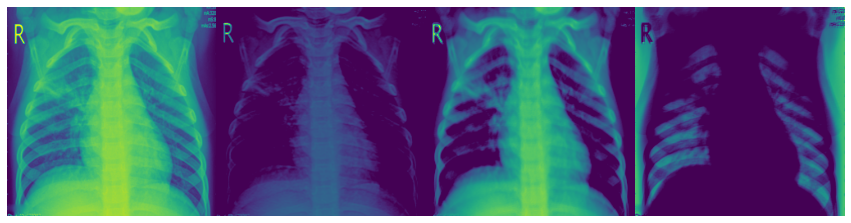

In [ ]:
feature_map(1,4)

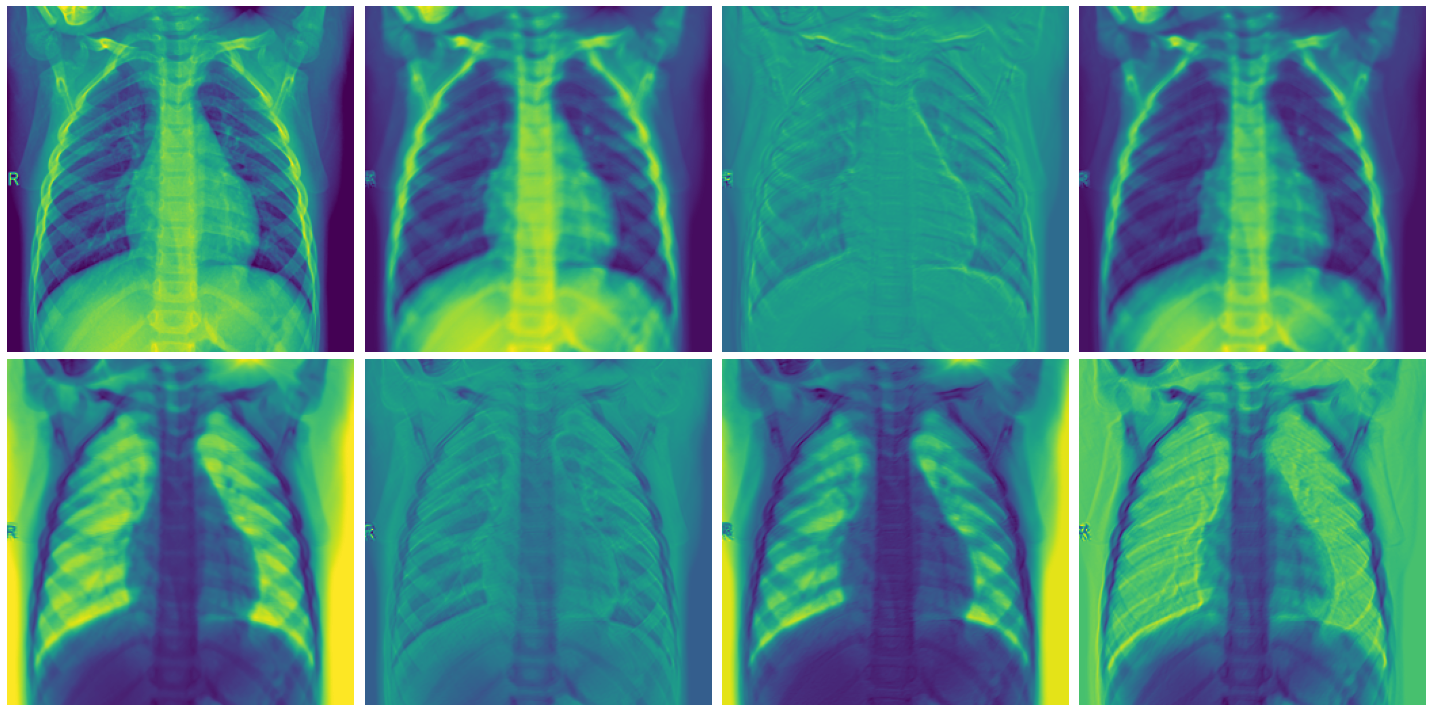

In [ ]:
feature_map(2,8)

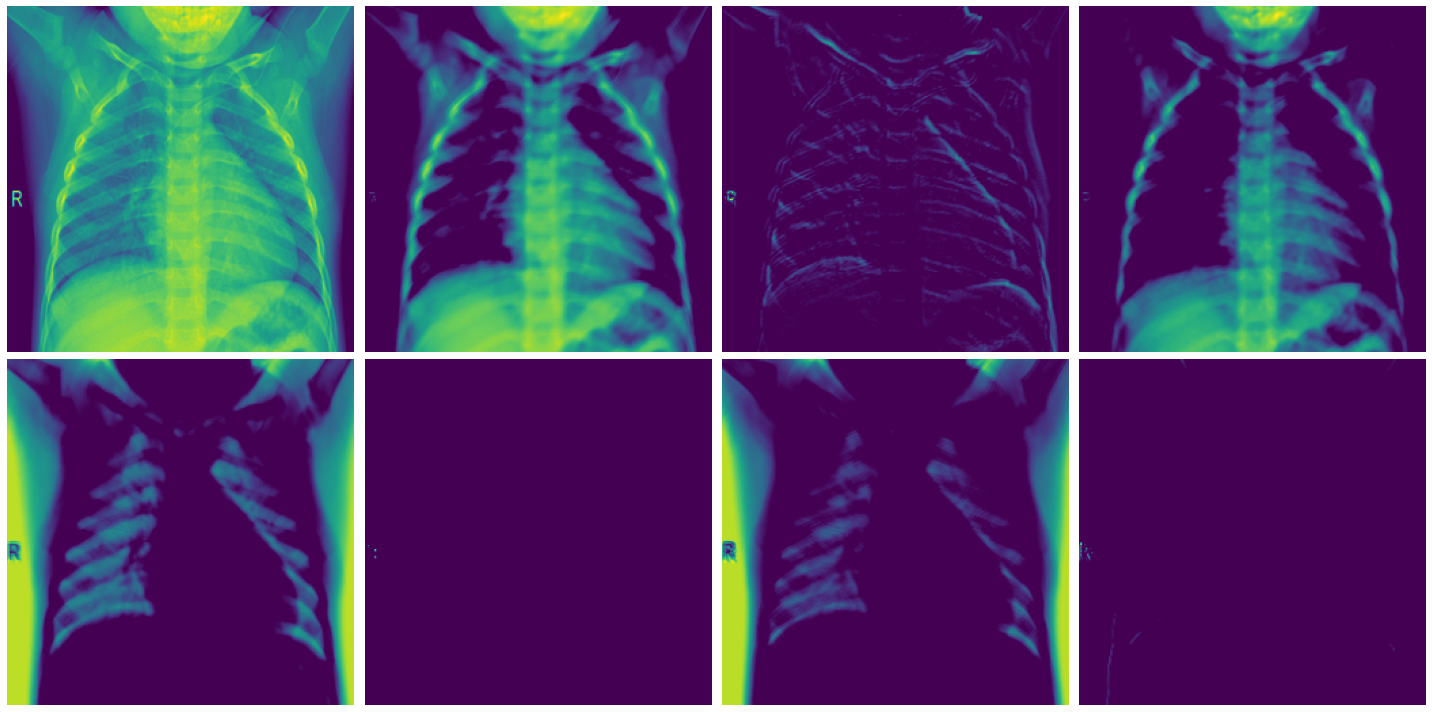

In [ ]:
feature_map(3,8)

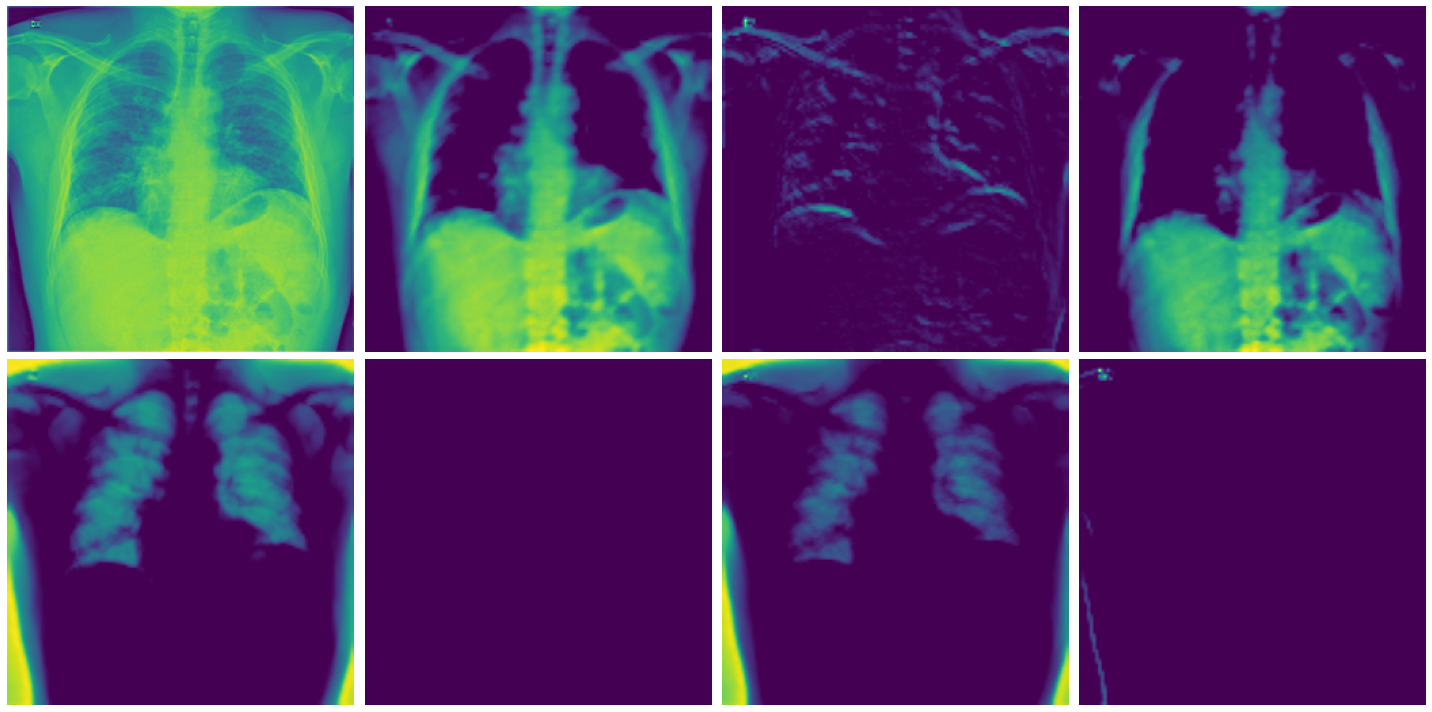

In [ ]:
feature_map(4,8)

## 4. Advanced Deep Learning Model: ResNet18

### Load and apply transfer learning on the pretrained model

In [ ]:
resnet = models.resnet18(pretrained=True)
optimizer = torch.optim.Adam(resnet.parameters(), lr=1e-4)
criterion = torch.nn.CrossEntropyLoss()

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


The following code block trains the model, which could take up to 3 hours. You can download the already-trained model after this section, so feel free to skip the training part.

In [ ]:
training_set_size = 5296
test_set_size = 624
epoches = 8

test_acc = []
test_loss = []

train_loss = []
train_acc = []
for epoch in range(epoches):
    i = 0
    loss_sum = 0
    correct, total = 0, 0
    while i < training_set_size: 
        data = getBatch(i, 16, 'train', (224, 224))
        images = data['data']
        label = data['label']
        images_reshaped = torch.zeros(images.size(0), 3, 224, 224)
        images_reshaped[:, 0, :, :] = images
        images_reshaped[:, 1, :, :] = images
        images_reshaped[:, 2, :, :] = images

        optimizer.zero_grad()
        output = resnet(images_reshaped)

        _, predicted = torch.max(output, 1)
        total += output.size(0)
        correct += (predicted == label).sum().item()

        loss = criterion(output, label)
        loss_sum += loss.item()
        loss.backward()
        optimizer.step()
        i += output.size(0)
    
    train_loss.append(loss_sum)
    train_acc.append(correct / total)
    
    ## Test loop
    with torch.no_grad():
        loss_sum = 0
        correct, total = 0, 0
        j = 0
        
        while j < test_set_size:
            data = getBatch(j, 16, 'train', (224, 224))
            images = data['data']
            label = data['label']
            images_reshaped = torch.zeros(images.size(0), 3, 224, 224)
            images_reshaped[:, 0, :, :] = images
            images_reshaped[:, 1, :, :] = images
            images_reshaped[:, 2, :, :] = images

            output = resnet(images_reshaped)
            loss = criterion(output, label)
            loss_sum += loss.item()
            
            predictions = torch.argmax(output, dim=1)
            num_correct = torch.sum(predictions == label)
            correct += num_correct
            total += output.size(0)
            j += output.size(0)
        
        test_acc.append(correct / total)
        test_loss.append(loss_sum)

Save the parameters in the model and the optimizer for later use:

In [ ]:
torch.save(resnet.state_dict(), '/content/model_params.pth')
torch.save(optimizer.state_dict(), '/content/optimizer_params.pth')

Load the model data:

In [ ]:
gdd.download_file_from_google_drive(file_id='1GjNaCCGvwP4JsX-t8qb5MmrDTnJA1WBn', dest_path='/content/model_params.pth')
resnet_data = torch.load('/content/model_params.pth')
resnet = models.resnet18(pretrained=True)
resnet.load_state_dict(resnet_data)

<All keys matched successfully>

### Visualizations

#### Accuracy

For some reason, the result was not saved: refer to the written report for the curve.

AttributeError: ignored

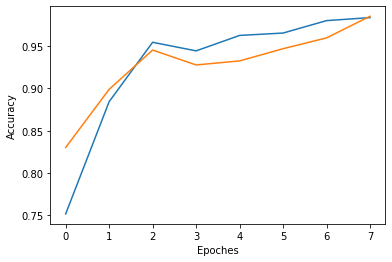

In [ ]:
plt.plot(train_acc, label='Training Accuracy')
plt.plot(test_acc, label='Test Accuracy')
plt.xlabel('Epoches')
plt.ylabel('Accuracy')
plt.title('Epoch vs Accuracy')
plt.legend()
plt.show()

#### Loss

For some reason, the result was not saved: refer to the written report for the curve.

In [ ]:
plt.plot(train_loss, label='Training Loss')
plt.plot(test_loss, label='Test Loss')
plt.xlabel('Epoches')
plt.ylabel('Loss')
plt.title('Epoch vs Loss')
plt.legend()
plt.show()

#### Confusion matrix

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
def test_resnet(model, device, data_loader):
  # Params:
  #   model-> instance of your trained model which extends nn.Module class
  #   device -> it is set to cuda already and is already stored in a variable called *device*
  #   data_loader -> dataloader for test dataset, already stored in a variable called *testloader*
  # Returns:
  #   accuracy(float)-> percentage of correct predictions made by your trained model
    model.eval()
    all_pred = []
    all_target = []
    j = 0
    test_set_size = 624
    correct = 0
    total = 0

    while j < test_set_size:
            data = getBatch(j, 16, 'train', (224, 224))
            images = data['data']
            label = data['label']
            images_reshaped = torch.zeros(images.size(0), 3, 224, 224)
            images_reshaped[:, 0, :, :] = images
            images_reshaped[:, 1, :, :] = images
            images_reshaped[:, 2, :, :] = images

            output = resnet(images_reshaped)
            
            predictions = torch.argmax(output, dim=1)
            all_target = np.append(all_target, label.view_as(predictions).detach().numpy())
            all_pred = np.append(all_pred, predictions.detach().numpy())
            total += output.size(0)
            correct += predictions.eq(label.view_as(predictions)).sum().item()
            
            j += output.size(0)

    # plot confusion matrix
    cm = confusion_matrix(all_target, all_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot() # 0-normal; 1-virus; 2-bacteria
    
    acc = 100 * correct / total
    print("Accuracy is %5.3f%%."%(acc))

Accuracy is 98.435%.


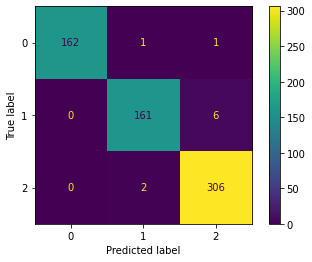

In [ ]:
test_resnet(resnet, dev, testloader)

#### GradCam

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:795: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


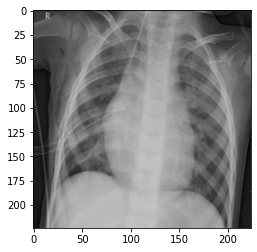

In [ ]:
target_layer = resnet.layer4[-1]
input_channel = getBatch(0, 1, 'train', (224, 224))['data']

input_tensor = torch.zeros(input_channel.size(0), 3, 224, 224)
input_tensor[:, 0, :, :] = input_channel
input_tensor[:, 1, :, :] = input_channel
input_tensor[:, 2, :, :] = input_channel

img = Image.open('/content/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/test/person149_bacteria_713.jpeg')
transform = transforms.Compose([
      transforms.ToTensor(),
      transforms.ToPILImage()
])
img = transform(img)
img = img.resize((224, 224))

transform1 = transforms.Compose([
      transforms.ToTensor()
])
img = transform1(img)

final_img = torch.zeros(224, 224, 3)
final_img[:, :, 0] = img[0, :, :]
final_img[:, :, 1] = img[0, :, :]
final_img[:, :, 2] = img[0, :, :]
plt.imshow(final_img, cmap='gray')

cam = GradCAM(model=resnet, target_layer=target_layer)
grayscale_cam = cam(input_tensor=input_tensor, target_category=1)
visualization = show_cam_on_image(np.array(final_img), grayscale_cam)

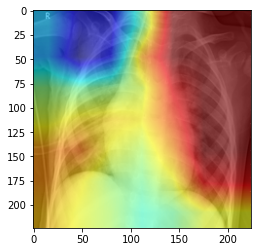

In [ ]:
plt.imshow(visualization)

## 5. Novel Architecture Deep Learning Model

### Define the Model

We're going to use Pytorch to implement the architecture mentioned in the paper https://arxiv.org/abs/2012.07564. \\
Here we implement the custom activation function first:

In [ ]:
class ALReLU(nn.Module):
    def __init__(self, alpha=0.01):
        super(ALReLU, self).__init__()
        self.alpha = alpha

    def forward(self, x):
        return x.clamp(min=0) + abs(x.clamp(max=0)) * self.alpha
    
    def backward(self, x):
        res = x.clone()
        res[res < 0] = -0.01
        res[res > 0] = 1
        return res

In [ ]:
class ALReLUNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=5)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3)
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3)
        self.conv5 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3)

        self.batch1 = nn.BatchNorm2d(32)
        self.batch2 = nn.BatchNorm2d(64)
        self.batch3 = nn.BatchNorm2d(128)
        self.batch4 = nn.BatchNorm2d(256)
        self.batch5 = nn.BatchNorm2d(512)

        self.alrelu = ALReLU()
        self.maxpool = nn.MaxPool2d((2, 2))
        self.fc = nn.Sequential(
            nn.Linear(512, 256),
            ALReLU(),
            nn.LayerNorm(256),
            nn.Dropout(0.4),
            nn.Linear(256, 3)
         )
        
    def forward(self, x):
        # group 1
        x = self.conv1(x)
        x = self.maxpool(x)
        x = self.batch1(x)
        x = nn.Dropout(0.1)(x)
        x = self.alrelu(x)

        # group 2
        x = self.conv2(x)
        x = self.maxpool(x)
        x = self.batch2(x)
        x = nn.Dropout(0.2)(x)
        x = self.alrelu(x)

        # group 3
        x = self.conv3(x)
        x = self.maxpool(x)
        x = self.batch3(x)
        x = nn.Dropout(0.3)(x)
        x = self.alrelu(x)

        # group 4
        x = self.conv4(x)
        x = self.maxpool(x)
        x = self.batch4(x)
        x = nn.Dropout(0.4)(x)
        x = self.alrelu(x)

        # group 5
        x = self.conv5(x)
        x = self.maxpool(x)
        x = self.batch5(x)
        x = nn.Dropout(0.5)(x)
        x = self.alrelu(x)

        x = F.adaptive_avg_pool2d(x, (1, 1))
        x = self.batch5(x)
        x = nn.Dropout(0.3)(x)

        x = torch.flatten(x, 1)
        x = self.fc(x)
        return F.softmax(x)

### Load Data


Train the model using the previously defined helper functions.

In [ ]:
trainset = getData(0, len(trainFilePaths), 'train', flattened=False, progress=True)
testset = getData(0, len(testFilePaths), 'test', flattened=False, progress=True)

test: 100%|###########################################################################| 624/624 [00:15<00:00, 41.04it/s]


In [ ]:
BATCH_SIZE = 8
validationset, trainset = torch.utils.data.random_split(trainset, [800, len(trainset)-800])

trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
validationloader = torch.utils.data.DataLoader(validationset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

In [ ]:
import gc
gc.collect()
torch.cuda.empty_cache()

### Visualizations

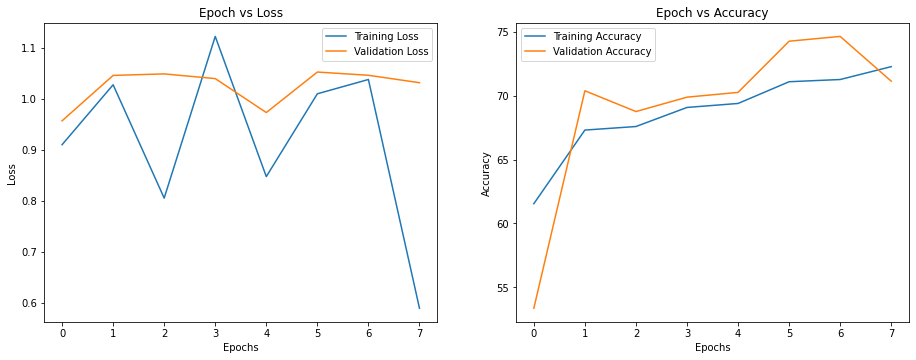

In [ ]:
plot_loss_accuracy(train_loss, train_acc, validation_loss, validation_acc)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Accuracy is 81.571%.


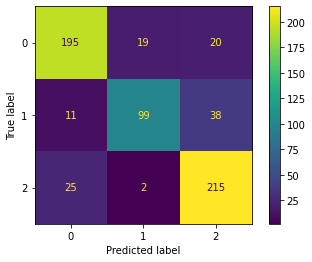

In [ ]:
test(alrelu_net, dev, testloader)